In [9]:
import numpy as np
import matplotlib.pyplot as plt
import swprocess
from evodcinv import EarthModel, Layer, Curve

In [2]:
names = None
workflow = "time-domain"
trim, trim_begin, trim_end = False, 0, 0.5

# Mute portions of the time-domain record to isolate surface wave energy. No muting is recommended.
# Mute method {"interactive"} and window_kwargs (see documenation for details).
mute, method, window_kwargs = False, "interactive", {}

# Zero pad the time-domain record to achieve a desired frequency step. Padding with df=0.5 is recommended.
pad, df = True, 0.1
transform = "fdbf"

# Minimum and maximum frequencies of interest (frequency in Hertz).
fmin, fmax = 3, 10

# Selection of trial velocities (velocity in m/s) with minimum, maximum, number of steps, and space {"linear", "log"}.  
vmin, vmax, nvel, vspace = 100, 500, 500, "linear"

# Weighting for "fdbf" {"sqrt", "invamp", "none"} (ignored for all other wavefield transforms). "sqrt" is recommended. 
fdbf_weighting = "sqrt"

# Steering vector for "fdbf" {"cylindrical", "plane"} (ignored for all other wavefield transforms). "cylindrical" is recommended.
fdbf_steering = "cylindrical"
snr = False

# Define noise and signal windows being and end times (time in seconds). Negative time refers to pre-trigger record.
noise_begin, noise_end =  0., 0.
signal_begin, signal_end = 0., 0.1

# Zero pad the noise and signal records to achieve a specified frequency step. Padding with df=1 is recommended.
pad_snr, df_snr = True, 1
%matplotlib qt5
settings = swprocess.Masw.create_settings_dict(workflow=workflow,
                                               trim=trim, trim_begin=trim_begin, trim_end=trim_end,
                                               mute=mute, method=method, window_kwargs=window_kwargs,
                                               transform=transform, fmin=fmin, fmax=fmax, pad=pad, df=df,
                                               vmin=vmin, vmax=vmax, nvel=nvel, vspace=vspace,
                                               weighting=fdbf_weighting, steering=fdbf_steering,
                                               snr=snr, noise_begin=noise_begin, noise_end=noise_end,
                                               signal_begin=signal_begin, signal_end=signal_end,
                                               pad_snr = pad_snr, df_snr=df_snr)

#settings = swprocess.Masw.create_settings_dict()
wavefieldtransform = swprocess.Masw.run(fnames="../../data/raw/SGY_10/1.sgy", settings=settings)
#wavefieldtransform = swprocess.Masw.run(fnames="../../data/raw/MAX_SGY/For_Masw_Resample.sgy", settings=settings)

In [3]:
wavefield_normalization = "frequency-maximum"

# Display the wavelength resolution limit.
display_lambda_res = False

# Display Yoon and Rix (2009) near-field criteria
display_nearfield = False
number_of_array_center_distances = 1
minimum_snr = 3.2

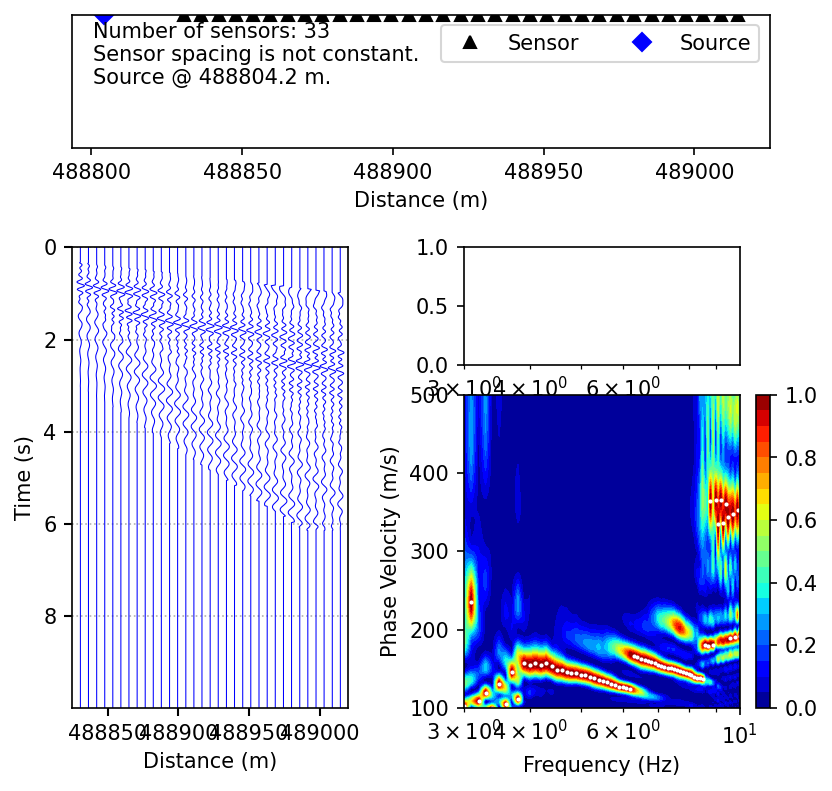

In [4]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
# plt.savefig('../reports/figures/seysmogramm.png')
plt.show()


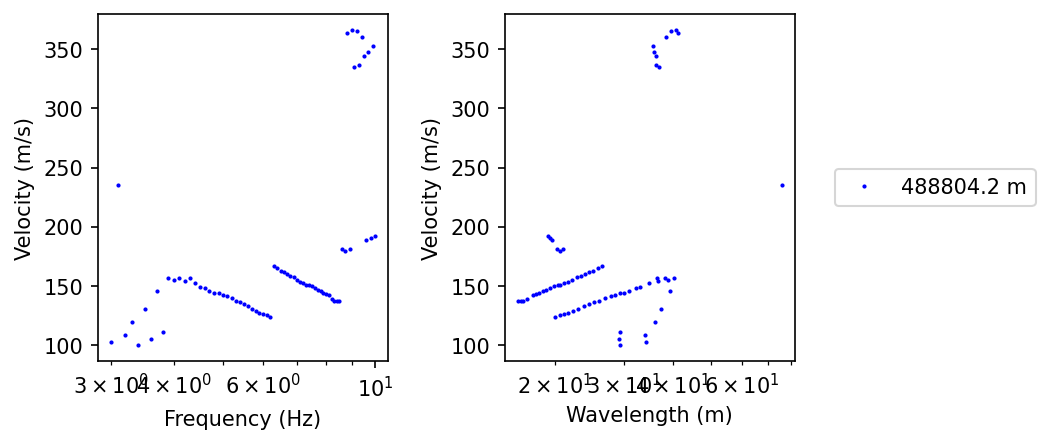

In [5]:
import matplotlib as mpl
# Domains in which to plot the experimental dispersion data.
domains = [
    ["frequency", "velocity"],
    ["wavelength", "velocity"],
]
%matplotlib inline
xtype = [x for x, _ in domains]
ytype = [y for _, y in domains]
label = [f"{wavefieldtransform.array.source.x:.1f} m"]

fig, axs = plt.subplots(ncols=len(xtype), figsize=(6,3), dpi=150, gridspec_kw=dict(wspace=0.4))
peak = swprocess.peaks.Peaks(wavefieldtransform.frequencies,
                             wavefieldtransform.find_peak_power(by="frequency-maximum"),
                             identifier=label)
peaksuite = swprocess.PeaksSuite.from_peaks([peak])
peaksuite.plot(xtype=xtype, ax=axs, ytype=ytype, plot_kwargs=dict(color="blue", label=label))

axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")
plt.show()

In [6]:
fr, velo = peaksuite.to_array("frequency", "velocity", peak.frequency)


In [26]:
velo.flatten()

array([124.04809619, 125.65130261, 126.45290581, 127.25450902,
       128.85771543, 130.46092184, 132.86573146, 134.46893788,
       136.07214429, 137.6753507 , 140.08016032, 141.68336673,
       142.48496994, 144.08817635, 144.08817635, 145.69138277,
       148.09619238, 148.89779559, 152.90581162, 156.91382766,
       154.50901804, 156.91382766, 155.31062124, 156.91382766])

In [29]:
model = EarthModel()

# Build model search boundaries from top to bottom
# First argument is the bounds of layer's thickness [km]
# Second argument is the bounds of layer's S-wave velocity [km/s]
model.add(Layer([0.001, 0.01], [0.01, 1.0]))
model.add(Layer([0.001, 0.01], [0.01, 1.0]))

# Configure model
model.configure(
    optimizer="cpso",  # Evolutionary algorithm
    misfit="rmse",  # Misfit function type
    optimizer_args={
        "popsize": 1000,  # Population size
        "maxiter": 100,  # Number of iterations
        "workers": -1,  # Number of cores
        "seed": 0,
    },
)

# Define the dispersion curves to invert
# period and velocity are assumed to be data arrays
curves = [Curve(((1/fr)).flatten()[9:33][::-1], velo.flatten()[9:33][::-1], 0, "rayleigh", "phase")]

# Run inversion
res = model.invert(curves)
print(res)

Run 1  |████████████████████| 100% [0:00:22 / 0:00:00] - Misfit: 140.8175


--------------------------------------------------------------------------------
Best model out of 100000 models (1 run)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0010    2.4495    1.0000    2.0772              0.0010    1.0000    0.4000
    1.0000    2.4495    1.0000    2.0772                   -    1.0000    0.4000
----------------------------------------          ------------------------------

Number of layers: 2
Number of parameters: 5
Best model misfit: 140.8175
--------------------------------------------------------------------------------


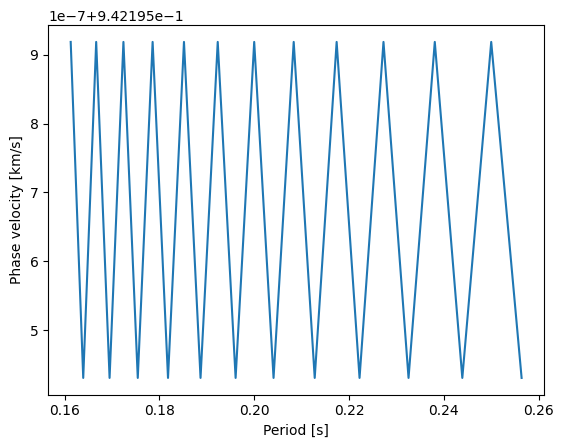

In [30]:
res.plot_curve(((1/fr)).flatten()[9:33][::-1], mode=0, wave='rayleigh',  type='phase')

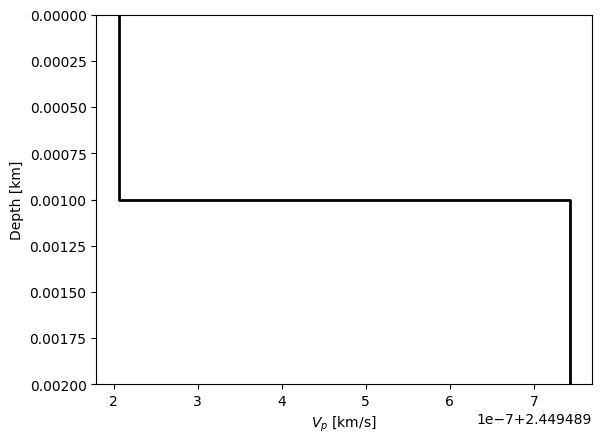

In [31]:
res.plot_model('vp')

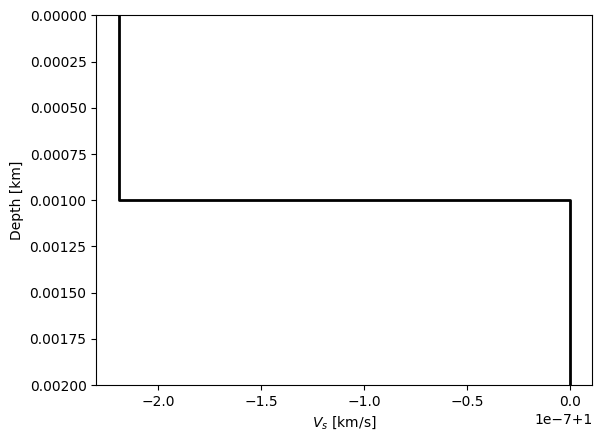

In [32]:
res.plot_model('vs')

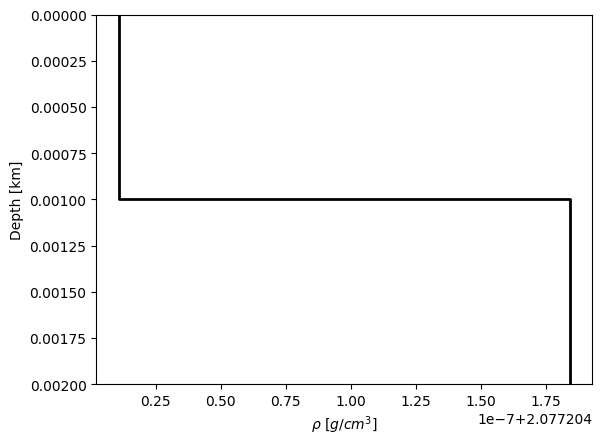

In [33]:
res.plot_model('rho')